# Проект e-commerce

Проект заключается в том, что необходимо проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько всего пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, необходимо провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

6. Используя python, построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию. В кластеризации можно выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Необходимо описать, как были созданы кластеры. 
7. Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров.

Необходимо предварительное исследование данных и сформулровать, что должно считаться покупкой.

In [1]:
import pandas as pd

In [2]:
customers = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/QXrVDUoQvFhIcg')
orders = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/0zWmh1bYP6REbw', parse_dates=[3,4,5,6,7])
order_items = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg')

### Предварительное исследование данных и выявление, что должно считаться покупкой.



Уникальные статусы заказов:

- created — создан
- approved — подтверждён
- invoiced — выставлен счёт
- processing — в процессе сборки заказа
- shipped — отгружен со склада
- delivered — доставлен пользователю
- unavailable — недоступен
- canceled — отменён

In [3]:
orders.query('order_status =="delivered"').order_status.count() - orders.query('order_status =="delivered"').order_delivered_customer_date.count()

8

In [36]:
orders.query('order_status =="delivered"').order_status.count() - orders.query('order_status =="delivered"').order_approved_at.count()

14

In [37]:
orders.query('order_status =="delivered"').order_status.count() - orders.query('order_status =="delivered"').order_delivered_carrier_date.count()

2

In [38]:
orders.query('order_status =="unavailable"').order_approved_at.count()

609

Выше провела предварительное исследование данных.

Обнаружено:

- 8 заказов со статусом "доставлено", но отсутствующей датой доставки (техническая ошибка или, возможно, потому что курьер не зафиксировал дату доставки);
- 14 заказов со статусом "доставлено", но отсутствующей датой и временем подтверждения оплаты заказа (техническая ошибка - не проставлялась дата оплаты, или, возможно, это товары в подарок, по акции, промокоду, за баллы);
- 2 заказа со статусом "доставлено", но отсутствующей датой и временем передачи заказа в логистическую службу (возможно, самовывоз);
- 609 заказов со статусом "недоступен", но с уже подтвержденной оплатой.

Заказы, которые считаем покупками: все, кроме тех, что со статусом "недоступен" и "отменён".

In [39]:
#Заказы, которые считаем покупками
purchase = orders[(orders.order_status != 'unavailable') | (orders.order_status != 'canceled')]

# Задание 1

Сколько у нас пользователей, которые совершили покупку только один раз? 

In [40]:
df_task1 = purchase.merge(customers, on='customer_id')

In [41]:
df_task1.groupby('customer_unique_id')['order_id'].count()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    1
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_id, Length: 96096, dtype: int64

In [42]:
(df_task1.groupby('customer_unique_id')['order_id'].count() == 1).sum()

93099

Ответ: 91816 пользователей совершили покупку только один раз.

# Задание 2

Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [43]:
#Пропущенные значения
purchase.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [44]:
#Изменили тип данных
purchase['order_purchase_timestamp'] = pd.to_datetime(purchase['order_purchase_timestamp'])

In [45]:
#считаем сколько всего месяцев в целом
(purchase.order_purchase_timestamp.max().to_period('M') - purchase.order_purchase_timestamp.min().to_period('M'))

<25 * MonthEnds>

In [46]:
purchase

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [47]:
# как нужно было
orders[(orders.order_status == 'unavailable') | (orders.order_status == 'canceled')]['order_status'].value_counts()/24

canceled       26.041667
unavailable    25.375000
Name: order_status, dtype: float64

In [48]:
#делим на количество месяцев
purchase[purchase.order_status!='delivered']['order_status'].value_counts()/24

shipped        46.125000
canceled       26.041667
unavailable    25.375000
invoiced       13.083333
processing     12.541667
created         0.208333
approved        0.083333
Name: order_status, dtype: float64

Ответ.
 В среднем не доставляется по разным причинам в месяц:
- 46.125 заказов отгружается со склада (останавливается на этом этапе, далее не доставлено)
- 12.541667 заказов в процессе сборки (останавливается на этом этапе, далее не отгружено) 
- 0.083333 заказов подтверждено (останавливается на этом этапе, далее не отправлено на сборку)

# Задание 3

По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [58]:
df_task3 = order_items.merge(orders, on = 'order_id')[['order_purchase_timestamp', 'product_id']]
df_task3

,order_purchase_timestamp,product_id
0,2017-09-13 08:59:02,4244733e06e7ecb4970a6e2683c13e61
1,2017-04-26 10:53:06,e5f2d52b802189ee658865ca93d83a8f
2,2018-01-14 14:33:31,c777355d18b72b67abbeef9df44fd0fd
3,2018-08-08 10:00:35,7634da152a4610f1595efa32f14722fc
4,2017-02-04 13:57:51,ac6c3623068f30de03045865e4e10089
...,...,...
112645,2018-04-23 13:57:06,4aa6014eceb682077f9dc4bffebc05b0
112646,2018-07-14 10:26:46,32e07fd915822b0765e448c4dd74c828
112647,2017-10-23 17:07:56,72a30483855e2eafc67aee5dc2560482
112648,2017-08-14 23:02:59,9c422a519119dcad7575db5af1ba540e


In [59]:
#создаем колонку с днем недели, в который была совершена покупка
df_task3['weekday'] = pd.to_datetime(df_task3['order_purchase_timestamp']).dt.day_name()
df_task3

,order_purchase_timestamp,product_id,weekday
0,2017-09-13 08:59:02,4244733e06e7ecb4970a6e2683c13e61,Wednesday
1,2017-04-26 10:53:06,e5f2d52b802189ee658865ca93d83a8f,Wednesday
2,2018-01-14 14:33:31,c777355d18b72b67abbeef9df44fd0fd,Sunday
3,2018-08-08 10:00:35,7634da152a4610f1595efa32f14722fc,Wednesday
4,2017-02-04 13:57:51,ac6c3623068f30de03045865e4e10089,Saturday
...,...,...,...
112645,2018-04-23 13:57:06,4aa6014eceb682077f9dc4bffebc05b0,Monday
112646,2018-07-14 10:26:46,32e07fd915822b0765e448c4dd74c828,Saturday
112647,2017-10-23 17:07:56,72a30483855e2eafc67aee5dc2560482,Monday
112648,2017-08-14 23:02:59,9c422a519119dcad7575db5af1ba540e,Monday


In [60]:
df_task3.groupby(['product_id', 'weekday'])['weekday'].count().sort_values().groupby(level=0).tail(1)

product_id                        weekday  
00066f42aeeb9f3007548bb9d3f33c38  Sunday        1
9c7dc7b21d811c74d038e40a5c13fce4  Monday        1
9c7ed530c8d9880f978748600f319c0c  Wednesday     1
9c7f6d8c7ecb53b1ded940560fad344a  Friday        1
9c8175269cef413a4b94529295cc1991  Wednesday     1
                                               ..
368c6c730842d78016ad823897a372db  Friday       67
53b36df67ebb7c41585e8d54d6772e08  Tuesday      76
aca2eb7d00ea1a7b8ebd4e68314663af  Thursday     89
99a4788cb24856965c36a24e339b6058  Monday       92
422879e10f46682990de24d770e7f83d  Wednesday    93
Name: weekday, Length: 32951, dtype: int64

In [70]:
#что у продуктов могут быть одинаковые значения по разным дням недели и вывести такие (если есть) через запятую например
def weekmax(x):
    Y = x.value_counts()
    k = Y[0]
    list_ = [Y.index[0]]
    for i, elem in enumerate(Y[1:]):
        if elem==k:
            list_.append(Y.index[i+1])
        else:
            return list_
    return list_

In [71]:
result_3 = pd.DataFrame(df_task3.dropna().groupby('product_id')['weekday'].apply(weekmax))
#ответ
result_3

,weekday
product_id,
00066f42aeeb9f3007548bb9d3f33c38,[Sunday]
00088930e925c41fd95ebfe695fd2655,[Tuesday]
0009406fd7479715e4bef61dd91f2462,[Thursday]
000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
000d9be29b5207b54e86aa1b1ac54872,[Tuesday]
...,...
fff6177642830a9a94a0f2cba5e476d1,"[Saturday, Sunday]"
fff81cc3158d2725c0655ab9ba0f712c,[Monday]
fff9553ac224cec9d15d49f5a263411f,[Friday]


#  Задание 4

Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [72]:
df_task4 = purchase.merge(customers, on = 'customer_id')
df_task4['year_month'] = pd.to_datetime(df_task4['order_approved_at']).dt.strftime('%Y-%m')

In [73]:
df_task4 = df_task4.groupby(['customer_unique_id', 'year_month'], as_index=False)['order_approved_at'].count().sort_values(['customer_unique_id', 'year_month'])
df_task4.head()

,customer_unique_id,year_month,order_approved_at
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1


In [74]:
def weeks_in_month(row):
    import calendar
    year = int(row.split('-')[0])
    month = int(row.split('-')[1])
    return calendar.monthrange(year, month)[1]/7

In [75]:
#создаем колонку с количеством недель в месяце
df_task4['weeks_in_month'] = df_task4['year_month'].apply(weeks_in_month)

In [76]:
df_task4['average_purchase'] = df_task4['order_approved_at']/df_task4['weeks_in_month']
#ответ
df_task4

,customer_unique_id,year_month,order_approved_at,weeks_in_month,average_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714,0.233333
...,...,...,...,...,...
97907,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1,4.285714,0.233333
97908,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1,4.428571,0.225806
97909,ffff371b4d645b6ecea244b27531430a,2017-02,1,4.000000,0.250000
97910,ffff5962728ec6157033ef9805bacc48,2018-05,1,4.428571,0.225806


# Задание 5

Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

In [77]:
df_task5 = purchase.merge(customers, on = 'customer_id')
df_task5['year_month'] = pd.to_datetime(df_task5['order_approved_at'])

In [78]:
df_task5 = df_task5[['customer_unique_id', 'year_month']].dropna()
df_task5

,customer_unique_id,year_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29
...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05
99437,da62f9e57a76d978d02ab5362c509660,2018-02-06 13:10:37
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 15:04:16
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:36:21


In [79]:
df_task5['cohort'] = df_task5.groupby('customer_unique_id')['year_month'].transform('min')
#Создадим колонку с датой первой покупки

In [80]:
df_task5.year_month = df_task5.year_month.dt.strftime('%Y-%m')
df_task5.cohort = df_task5['cohort'].dt.strftime('%Y-%m')

In [81]:
df_task5

,customer_unique_id,year_month,cohort
0,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02
...,...,...,...
99436,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03
99437,da62f9e57a76d978d02ab5362c509660,2018-02,2018-02
99438,737520a9aad80b3fbbdad19b66b37b30,2017-08,2017-08
99439,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01


In [82]:
df_task5 = df_task5.query("'2017-01' <= cohort <= '2017-12'") \
    .groupby(["cohort", "year_month"], as_index=False) \
    .agg({"customer_unique_id": "nunique"})
#фильтруем по условиям, группируем даты и считаем кол-во уникальных айди

In [83]:
df_task5["cohort"] = pd.to_datetime(df_task5["cohort"]).dt.to_period("m")
df_task5["year_month"] = pd.to_datetime(df_task5["year_month"]).dt.to_period("m")
#превращаем в номер месяца

In [84]:
df_task5

,cohort,year_month,customer_unique_id
0,2017-01,2017-01,726
1,2017-01,2017-02,4
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3
...,...,...,...
166,2017-12,2018-04,14
167,2017-12,2018-05,11
168,2017-12,2018-06,9
169,2017-12,2018-07,2


In [85]:
from operator import attrgetter
df_task5['period'] = (df_task5.year_month - df_task5.cohort).apply(attrgetter("n"))
#считаем месяц покупки, начинаем с нулевого - месяц первой покупки

In [86]:
df_task5

,cohort,year_month,customer_unique_id,period
0,2017-01,2017-01,726,0
1,2017-01,2017-02,4,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
...,...,...,...,...
166,2017-12,2018-04,14,4
167,2017-12,2018-05,11,5
168,2017-12,2018-06,9,6
169,2017-12,2018-07,2,7


In [87]:
df_task5 = df_task5.pivot(index='cohort', columns = 'period', values = 'customer_unique_id').fillna(0)
#считаем

In [88]:
df_task5

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,,
2017-01,726.0,4.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,0.0,2.0,2.0,6.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1736.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,2.0,4.0,2.0,5.0,3.0,3.0,2.0,1.0,1.0,4.0,0.0
2017-03,2643.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,10.0,4.0,6.0,3.0,4.0,6.0,2.0,4.0,0.0
2017-04,2323.0,14.0,5.0,4.0,7.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,2.0,1.0,2.0,2.0,5.0,0.0,0.0
2017-05,3592.0,19.0,18.0,14.0,11.0,12.0,15.0,6.0,9.0,11.0,10.0,12.0,7.0,2.0,7.0,9.0,0.0,0.0,0.0
2017-06,3148.0,15.0,11.0,13.0,8.0,11.0,12.0,7.0,4.0,7.0,10.0,12.0,5.0,4.0,6.0,0.0,0.0,0.0,0.0
2017-07,3843.0,20.0,13.0,8.0,13.0,7.0,12.0,4.0,7.0,9.0,9.0,12.0,5.0,10.0,0.0,0.0,0.0,0.0,0.0
2017-08,4204.0,28.0,15.0,11.0,16.0,22.0,11.0,11.0,5.0,7.0,10.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-09,4148.0,27.0,20.0,14.0,18.0,11.0,9.0,9.0,13.0,7.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [89]:
for row in df_task5.iterrows():
    index = row[0]
    df_task5.loc[index] = row[1]/row[1][0]

In [90]:
df_task5

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.005510,0.002755,0.001377,0.004132,0.001377,0.005510,0.001377,0.001377,0.000000,0.002755,0.002755,0.008264,0.004132,0.001377,0.001377,0.002755,0.004132,0.001377
2017-02,1.0,0.002304,0.002304,0.001728,0.004032,0.001152,0.002304,0.001728,0.001152,0.002304,0.001152,0.002880,0.001728,0.001728,0.001152,0.000576,0.000576,0.002304,0.000000
2017-03,1.0,0.004919,0.003405,0.003405,0.003405,0.001513,0.001513,0.003027,0.003027,0.001135,0.003784,0.001513,0.002270,0.001135,0.001513,0.002270,0.000757,0.001513,0.000000
2017-04,1.0,0.006027,0.002152,0.001722,0.003013,0.002583,0.003444,0.002583,0.003444,0.001722,0.002152,0.000861,0.000861,0.000430,0.000861,0.000861,0.002152,0.000000,0.000000
2017-05,1.0,0.005290,0.005011,0.003898,0.003062,0.003341,0.004176,0.001670,0.002506,0.003062,0.002784,0.003341,0.001949,0.000557,0.001949,0.002506,0.000000,0.000000,0.000000
2017-06,1.0,0.004765,0.003494,0.004130,0.002541,0.003494,0.003812,0.002224,0.001271,0.002224,0.003177,0.003812,0.001588,0.001271,0.001906,0.000000,0.000000,0.000000,0.000000
2017-07,1.0,0.005204,0.003383,0.002082,0.003383,0.001821,0.003123,0.001041,0.001821,0.002342,0.002342,0.003123,0.001301,0.002602,0.000000,0.000000,0.000000,0.000000,0.000000
2017-08,1.0,0.006660,0.003568,0.002617,0.003806,0.005233,0.002617,0.002617,0.001189,0.001665,0.002379,0.001665,0.001189,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-09,1.0,0.006509,0.004822,0.003375,0.004339,0.002652,0.002170,0.002170,0.003134,0.001688,0.002652,0.000723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [91]:
df_task5[3].idxmax()

Period('2017-06', 'M')

Ответ. Когорта с самым высоким retention относится маю 2017г.

# Задание 6

Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.
Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров

In [108]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [110]:
df_task6 = (purchase.merge(customers, on = 'customer_id')).merge(order_items, on = 'order_id')
df_task6['order_purchase_timestamp'] = pd.to_datetime(df_task6['order_purchase_timestamp'])

In [112]:
from datetime import timedelta


last_day = df_task6.order_purchase_timestamp.max()

today = last_day + timedelta(days=1)

Считаем для каждого пользователя R - время от последней покупки пользователя до текущей даты (в днях), F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.


In [113]:
df_task6

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [114]:
RFM = df_task6 \
    .groupby('customer_unique_id') \
    .agg({'order_purchase_timestamp': lambda x: (today - x.max()).days, 'product_id': lambda x: len(x), 'price': lambda x: x.sum()}) \
    .rename(columns={'order_purchase_timestamp': 'R', 'product_id': 'F', 'price': 'M'})

In [115]:
RFM

,R,F,M
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
0000f46a3911fa3c0805444483337064,542,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
0004aac84e0df4da2b147fca70cf8255,293,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,2,1570.00
fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89
ffff371b4d645b6ecea244b27531430a,573,1,89.90


Создаю ниже 4 кластера по квантилям. Каждый квантиль содержит 20% пользователей по каждому параметру RFM

<Axes: >

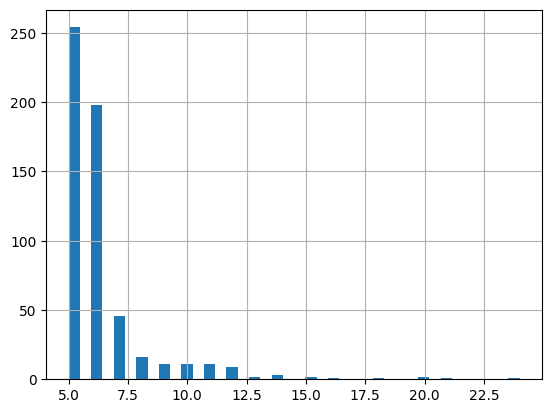

In [128]:
RFM[RFM['F']>4]['F'].hist(bins = 40)

In [133]:
RFM_seg = RFM.quantile(q=[0.20, 0.40, 0.60, 0.80]).to_dict()

In [134]:
RFM_seg
#Сначала я получаю квантиль для каждого параметра

{'R': {0.2: 98.0, 0.4: 182.0, 0.6: 273.0, 0.8: 389.0},
 'F': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'M': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [135]:
#здесь каждому пользователю я присваиваю номер, который показывает к какому сегменту относится пользователь: от 1 до 5.
def to_seg (a,b,c):
    if a <= c[b][0.20]:
        return 1
    elif a <= c[b][0.40]:
        return 2
    elif a <= c[b][0.60]:
        return 3
    elif a <= c[b][0.80]:
        return 4
    else:
        return 5

In [136]:
def to_seg_F(row):
    if row==1:
        return 1
    elif row==2:
        return 2
    elif row<5:
        return 3
    elif row<7:
        return 4
    else:
        return 5

In [137]:
#теперь получаются RFM-показатели для каждого пользователя
RFM['R_seg'] = RFM['R'].apply(to_seg, args=('R', RFM_seg, ))
RFM['F_seg'] = RFM['F'].apply(to_seg_F)
RFM['M_seg'] = RFM['M'].apply(to_seg, args=('M', RFM_seg, ))
RFM['R_seg'] = 6 - RFM['R_seg']

<Axes: >

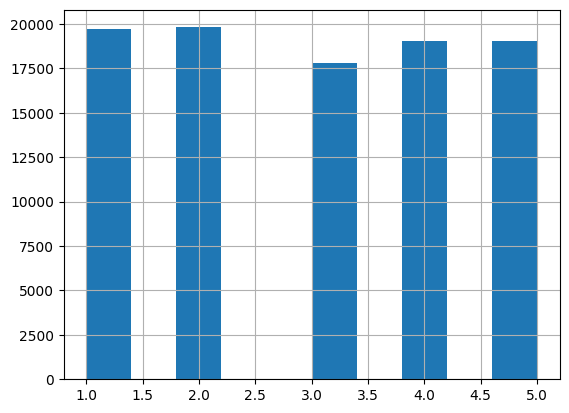

In [141]:
RFM['M_seg'].hist()

In [142]:
#здесь объединяются оценки R, F и M в сегменты RFM.
RFM['RFMseg'] = RFM.R_seg.map(str) + RFM.F_seg.map(str) + RFM.M_seg.map(str)

In [143]:
RFM

,R,F,M,R_seg,F_seg,M_seg,RFMseg
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,4,1,1,411
0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,293,1,180.00,2,1,5,215
...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,452,2,1570.00,1,2,5,125
fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89,3,1,2,312
ffff371b4d645b6ecea244b27531430a,573,1,89.90,1,1,3,113


In [144]:
for segment in sorted(list(RFM.RFMseg.unique())):
    df_seg = RFM[RFM.RFMseg == segment]
    print('--------------------------------------------------------------')
    print('Сегмент:', segment)
    print(f'Численность группы:  {len(df_seg)}')
    print(f'Доля группы : {round(len(df_seg)/len(RFM)*100, 2)} %')
    print(f'Границы сегмента по давности : {df_seg.R.min()} - {df_seg.R.max()}')
    print(f'Границы сегмента по частоте покупок : {df_seg.F.min()} - {df_seg.F.max()}')
    print(f'Границы сегмента по сумме покупок : {df_seg.M.min()} - {df_seg.M.max()}')

--------------------------------------------------------------
Сегмент: 111
Численность группы:  3990
Доля группы : 4.18 %
Границы сегмента по давности : 390 - 700
Границы сегмента по частоте покупок : 1 - 1
Границы сегмента по сумме покупок : 3.9 - 39.9
--------------------------------------------------------------
Сегмент: 112
Численность группы:  3737
Доля группы : 3.92 %
Границы сегмента по давности : 390 - 729
Границы сегмента по частоте покупок : 1 - 1
Границы сегмента по сумме покупок : 39.92 - 69.9
--------------------------------------------------------------
Сегмент: 113
Численность группы:  3135
Доля группы : 3.29 %
Границы сегмента по давности : 390 - 701
Границы сегмента по частоте покупок : 1 - 1
Границы сегмента по сумме покупок : 69.98 - 109.9
--------------------------------------------------------------
Сегмент: 114
Численность группы:  2909
Доля группы : 3.05 %
Границы сегмента по давности : 390 - 700
Границы сегмента по частоте покупок : 1 - 1
Границы сегмента по су